In [1]:
import os
import pandas as pd
import glob
import numpy as np
import xarray as xr
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import time
import cartopy.crs as ccrs
import cartopy

from precip_model_functions import *

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


# Orography

In [2]:
orog = xr.open_dataset("/global/cfs/projectdirs/m3522/cmip6/ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc")
landmask = xr.open_dataset("/global/cfs/projectdirs/m3522/cmip6/ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc").LSM


5859.103


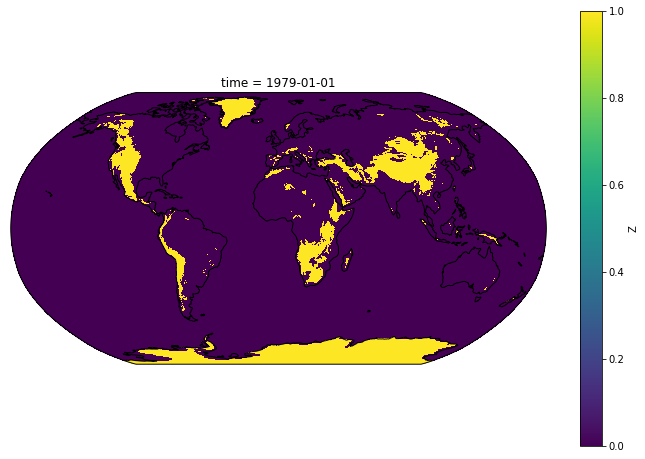

In [3]:
orogm0 = orog.Z.isel(time=0)/9.80665
print(np.array(orogm0.max(dim=["latitude","longitude"])))

heightcutoff=1000.

orogm = (orogm0 > heightcutoff)*1

plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
orogm.plot(ax=ax,transform=ccrs.PlateCarree())#,cmap=plt.cm.Greys,levels=np.linspace(0,np.array(orogm.max(dim=["latitude","longitude"])),1000))


# Precip 99th percentile

In [ ]:
def extract(path,name):
    """opens a file in path that contains name"""
    print(name)
    #print(os.path.join(path,'*'+name+'*'))
    listing = glob.glob(os.path.join(path,'*'+name+'*'))
    if len(listing) == 0:
        raise ValueError('No such file')
    if len(listing) > 1:
        raise ValueError('More than one file correspond to the name ' + name + ':' + str(listing))
    else :
        data = xr.open_dataset(listing[0])
        return data

path_to_precip = "/global/cfs/projectdirs/m3522/cmip6/obs4mip/NASA-GSFC/TRMM/observations/atmos/pr/3hr/NASA-GSFC/TRMM/*/"


#months = pd.date_range(start='1/1/2011', end = '12/31/2013', freq='MS')
#monthstr = [str(d)[:4]+str(d)[5:7]+str(d)[8:10] for d in months]
#
#precip_all = xr.concat([extract(path_to_precip,m)['pr'] for m in monthstr], dim = "time")
#daily_precip_all = precip_all.resample(time="1D").mean(dim="time")
#t = time.time()
#ninenine = daily_precip_all.quantile(0.99,"time")
#print(time.time()-t)

In [5]:
ninenine = xr.open_dataset("/global/cscratch1/sd/qnicolas/data/pr/pr_trmm_99pctile_2010-2013.nc").pr

In [9]:
landmask2 = 1.*landmask.sel(latitude=slice(49.88, -49.88)).isel(time=0).fillna(0.)
orogm2 = orogm.sel(latitude=slice(49.88, -49.88))
ninenine2 = ninenine.rename({'lat': 'latitude','lon': 'longitude'}).fillna(0.).interp_like(landmask2)*24*3600
masked = landmask2*ninenine2

In [34]:
def mean_era5(month1,month2,varid):
    """Compute the mean of a 3D or 4D ERA5 variable for months between month1 and month2 (included),
    month1/2 must be of the type "200001"
    varid gives the id of the variable in era5, e.g. '128_135_w' for omega
    """
    
    timeframe = pd.date_range(pd.to_datetime(month1,format="%Y%m"),pd.to_datetime(month2,format="%Y%m"), freq="MS")
    path = "/global/project/projectdirs/m3310/wboos/era5monthly/"
    
    era5varsum = 0
    count = len(range(int(month1[:4]),int(month2[:4])+1))
    for y in [str(year) for year in range(int(month1[:4]),int(month2[:4])+1)]:
        timeframe_y = [d for d in timeframe if d.year == int(y)]
        era5var = xr.open_dataset(glob.glob(path+"*/e5.mnth.mean.an.*.%s.*.%s*.nc"%(varid,y))[0])
        varname = list(era5var.data_vars)[0] #get name of the main variable, eg 'W' for omega
        era5var1 = era5var[varname].sel(time=timeframe_y) #.sel(longitude=slice(lonlat[0],lonlat[1]),latitude=slice(lonlat[3],lonlat[2]))
        
        era5varsum += era5var1.mean("time")
    return era5varsum/count

nlat=15
nlon=45
test = xr.DataArray(np.zeros((nlat,nlon)), 
                    dims=['latitude', 'longitude'],
                    coords={'latitude': np.linspace(49,-49,nlat),
                            'longitude': np.linspace(0.,360.,nlon)})

u = mean_era5("201001","201312","228_246_100u").sel(latitude=slice(50., -50.)).interp_like(test)
v = mean_era5("201001","201312","228_247_100v").sel(latitude=slice(50., -50.)).interp_like(test)
u

<xarray.DataArray 'VAR_100U' (latitude: 15, longitude: 45)>
array([[ 1.342819e+00,  1.141162e+00,  4.232141e-01, ...,  3.665368e+00,
         2.818351e+00,           nan],
       [ 7.753540e-01,  1.620784e+00,  1.426954e+00, ...,  1.697993e+00,
        -2.609910e-03,           nan],
       [ 1.301078e+00,  1.447260e+00,  1.705290e+00, ..., -3.266709e-01,
         8.120182e-01,           nan],
       ...,
       [ 3.191201e+00,  2.439085e+00,  3.004635e-01, ...,  3.212577e+00,
         3.197706e+00,           nan],
       [ 7.627696e+00,  7.485557e+00,  7.002446e+00, ...,  6.577568e+00,
         7.201592e+00,           nan],
       [ 9.379903e+00,  9.646793e+00,  9.847191e+00, ...,  8.344084e+00,
         8.494134e+00,           nan]])
Coordinates:
  * latitude   (latitude) float64 49.0 42.0 35.0 28.0 ... -35.0 -42.0 -49.0
  * longitude  (longitude) float64 0.0 8.182 16.36 24.55 ... 343.6 351.8 360.0

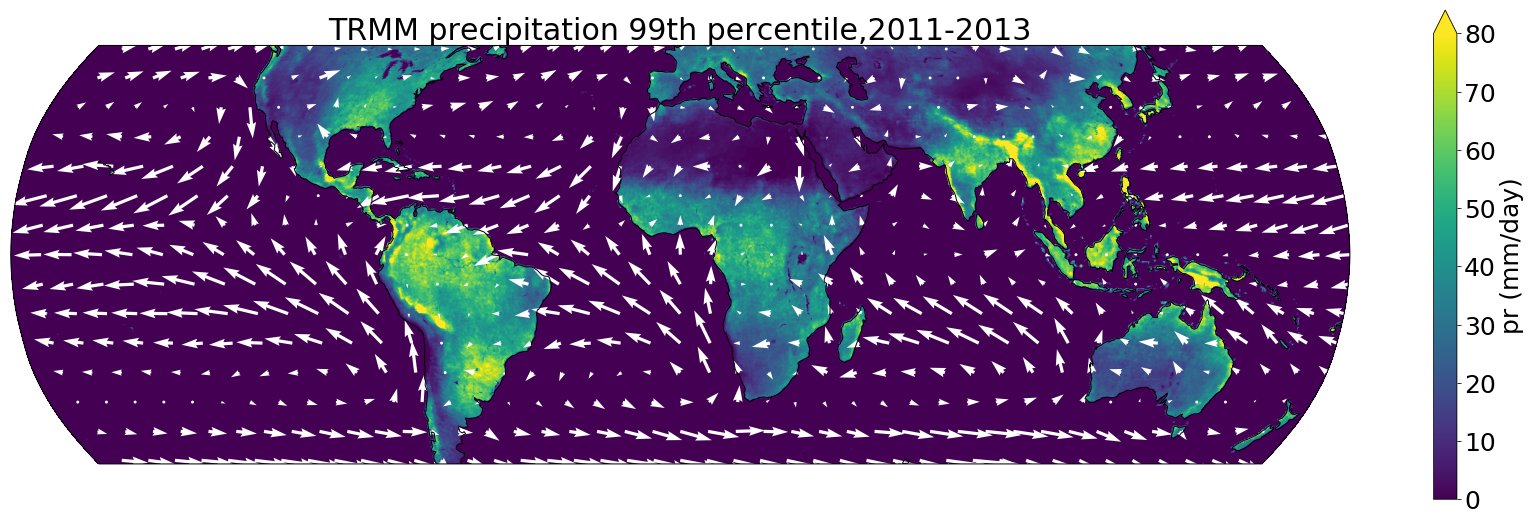

In [41]:
plt.figure(figsize=(30,9))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
masked.plot(ax=ax,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,81.,10)},levels=np.linspace(0,80,1000))
plt.rcParams.update({'font.size': 25})
ax.set_title("TRMM precipitation 99th percentile,2011-2013")

#Wind Vectors
X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
Y = u.longitude.expand_dims({"latitude":u.latitude})
ax.quiver(np.array(Y),np.array(X), np.array(u), np.array(v), transform=ccrs.PlateCarree(),color="w",scale=100,scale_units="height") #np.hypot(np.array(u),np.array(v)) to color the arrows according to magnitude

##Z=1000m contours
#kw = {'levels':[0,1000], 'colors':['w']}
#orogm2.plot.contour(ax=ax,transform=ccrs.PlateCarree(),**kw)

##Boxes
#for c in ["nepal","Sandes","Candes","california"]:
#    ax.add_patch(mpatches.Rectangle(xy=[box[c]["small"][0], box[c]["small"][2]], width=box[c]["small"][1]-box[c]["small"][0], height=box[c]["small"][3]-box[c]["small"][2],
#                                    edgecolor='r',
#                                    fill = False,
#                                    lw=2,
#                                    transform=ccrs.PlateCarree())
#                 )

# JJA 200hpa PV variance

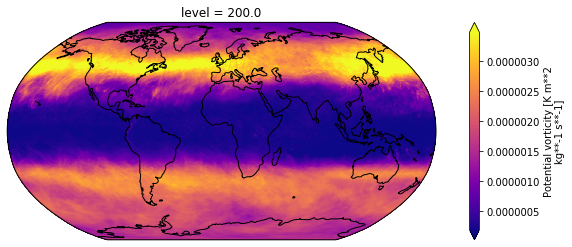

In [10]:
pvvarjja = xr.open_dataset("/global/cscratch1/sd/qnicolas/data/pv/composite/e5.oper.an.pl.128_060_pv.regn320sc.2016_2017_JJA_200hpa_0Z_std.nc")

plt.figure(figsize=(12,4))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
pvvarjja.PV.plot(ax=ax,transform=ccrs.PlateCarree(),robust=True,cmap=plt.cm.plasma)

# DJF 200hpa PV variance

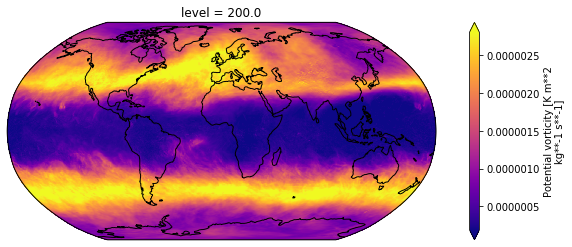

In [11]:
pvvardjf = xr.open_dataset("/global/cscratch1/sd/qnicolas/data/pv/composite/e5.oper.an.pl.128_060_pv.regn320sc.2016_2017_DJF_200hpa_0Z_std.nc")

plt.figure(figsize=(12,4))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
pvvardjf.PV.plot(ax=ax,transform=ccrs.PlateCarree(),robust=True,cmap=plt.cm.plasma)

In [12]:
orogm2 = orogm.sel(latitude=slice(49.88, -49.88))
pvvarjja2 = pvvarjja.PV.sel(latitude=slice(49.88, -49.88)).isel(time=0,level=0)
pvvardjf2 = pvvardjf.PV.sel(latitude=slice(49.88, -49.88)).isel(time=0,level=0)

ninenine2 = ninenine.rename({'lat': 'latitude','lon': 'longitude'}).interp_like(orogm2)

In [13]:
nn2max =     np.array(ninenine2.max(dim=["latitude","longitude"]))
or2max =     np.array(orogm2.max(dim=["latitude","longitude"]))
pvvjja2max = np.array(pvvarjja2.max(dim=["latitude","longitude"]))
pvvdjf2max = np.array(pvvardjf2.max(dim=["latitude","longitude"]))

# orog * 99th precip percentile

Text(0.5, 1.0, '(orog>1000m)*(precip 99th percentile), normalized')

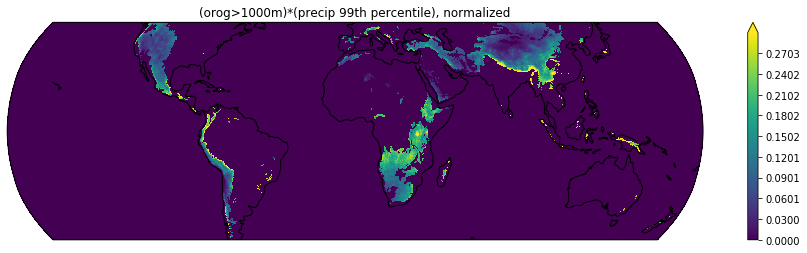

In [14]:
test2 = np.abs((ninenine2/nn2max)*(orogm2/or2max))
plt.figure(figsize=(16,4))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
test2.plot(ax=ax,transform=ccrs.PlateCarree(),levels=np.linspace(0.,0.3,1000))
ax.set_title("(orog>1000m)*(precip 99th percentile), normalized")

# JJA PV variance * orog * 99th precip percentile

IndexError: index -1 is out of bounds for axis 0 with size 0

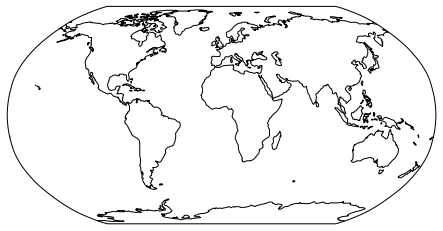

In [15]:
test = np.abs(((ninenine2/nn2max)*(orogm2/or2max)*(pvvarjja2/pvvjja2max))**3)
plt.figure(figsize=(16,4))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
test.plot(ax=ax,transform=ccrs.PlateCarree(),robust=True)

ax.set_title("(orog>1000m)*(precip 99th percentile)*(JJA 200hpa PV variance), normalized")

# DJF PV variance * orog * 99th precip percentile

In [ ]:
test = np.abs(((ninenine2/nn2max)*(orogm2/or2max)*(pvvardjf2/pvvdjf2max)))**3
plt.figure(figsize=(16,4))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
test.plot(ax=ax,transform=ccrs.PlateCarree(),robust=True)

ax.set_title("(orog>1000m)*(precip 99th percentile)*(DJF 200hpa PV variance), normalized")

# Precip breakdown

In [ ]:
gpcp = xr.open_dataset("/global/cfs/projectdirs/m3522/cmip6/obs4mip/observations/NASA-GSFC/Obs-GPCP/GPCP/V2.3/atmos/pr/pr_GPCP-SG_L3_v2.3_197901-201710.nc")
gpcp_mean = 24*3600*gpcp.pr.mean(["time","lon"])


In [ ]:
lats = np.array(gpcp_mean.lat)
prmean = np.array(gpcp_mean)
idx = 24

plt.plot(prmean,lats)
print(np.sum(np.cos(lats[idx:-idx]*np.pi/180)*(2.5*np.pi/180)*prmean[idx:-idx])/np.sum(np.cos(lats[idx:-idx]*np.pi/180)*(2.5*np.pi/180)))

print(np.sum(np.cos(lats*np.pi/180)*(2.5*np.pi/180)*prmean)/2)

#plt.figure(figsize=(16,8))
#ax = plt.axes(projection=ccrs.Robinson())
#ax.coastlines()
#gpcp_mean.plot(ax=ax,transform=ccrs.PlateCarree(),robust=True)

In [ ]:
#with TRMM data
trmm =xr.open_dataset("/global/cscratch1/sd/wboos/data/trmm/pr_TRMM-L3_v7-7A_199801-201312.nc")
trmm_mean = 24*3600*trmm.pr.mean(["time","lon"])
trmm_tmean = 24*3600*trmm.pr.mean(["time"])
trmm_99tmean = 24*3600*ninenine

orogm3 = orogm2.rename({'latitude':'lat','longitude':'lon'}).interp_like(trmm_tmean)
trmm_orog = 1*trmm_tmean*orogm3.fillna(0)
trmm_orog99 = 1*trmm_99tmean*orogm3.fillna(0)

latc = 50.

print(float(np.mean(trmm_mean.sel(lat=slice(-latc,latc)))))
print(float(np.mean(trmm_99tmean.sel(lat=slice(-latc,latc)))))
print(float(np.sum(trmm_orog.sel(lat=slice(-latc,latc))))/float(np.sum(orogm3.sel(lat=slice(-latc,latc)))))
print(float(np.sum(trmm_orog99.sel(lat=slice(-latc,latc))))/float(np.sum(orogm3.sel(lat=slice(-latc,latc)))))


#print(np.sum(np.cos(lats[idx:-idx]*np.pi/180)*(2.5*np.pi/180)*prmean[idx:-idx])/np.sum(np.cos(lats[idx:-idx]*np.pi/180)*(2.5*np.pi/180)))
#print(np.sum(np.cos(lats[idx:-idx]*np.pi/180)*(2.5*np.pi/180)*prmeanorog[idx:-idx])/np.sum(np.cos(lats[idx:-idx]*np.pi/180)*(2.5*np.pi/180)))


plt.figure(figsize=(16,4))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
trmm_tmean.plot(ax=ax,transform=ccrs.PlateCarree(),robust=True,cbar_kwargs={"label":"pr (mm/day)","ticks":range(10)},levels=np.linspace(0,9,1000))
kw = {'levels':[0,1], 'colors':['w']}
orogm2.plot.contour(ax=ax,transform=ccrs.PlateCarree(),**kw)
ax.set_title("Global mean precipitation (TRMM), 1998-2013 and 1000m height contour")


plt.figure(figsize=(16,4))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
trmm_orog.plot(ax=ax,transform=ccrs.PlateCarree(),robust=True,cbar_kwargs={"label":"pr (mm/day)","ticks":range(10)},levels=np.linspace(0,9,1000))
ax.set_title("Global mean precipitation (TRMM), 1998-2013 where Z>1000m")

In [ ]:
plt.figure(figsize=(16,4))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
trmm_99tmean.plot(ax=ax,transform=ccrs.PlateCarree(),robust=True,cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0,100,10)},levels=np.linspace(0,90,1000))
#kw = {'levels':[0,1], 'colors':['w']}
#orogm2.plot.contour(ax=ax,transform=ccrs.PlateCarree(),**kw)
ax.set_title("Precipitation 99th percentile (TRMM), 1998-2013")


plt.figure(figsize=(16,4))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
trmm_orog99.plot(ax=ax,transform=ccrs.PlateCarree(),robust=True,cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0,100,10)},levels=np.linspace(0,90,1000))
ax.set_title("Precipitation 99th percentile (TRMM), 1998-2013 where Z>1000m")